In [ ]:
# Notebook created by Mahdiyeh Behjat Khatooni
# Date: 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn import datasets, metrics, svm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import roc_auc_score

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

data preparation

In [2]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import gzip
# unzip data set
train_file = gzip.open('mnist/train-images-idx3-ubyte.gz','r')

image_size = 28
train_examples = 60000

import numpy as np
# train set
train_file.read(16)
train_buf = train_file.read()
train_data = np.frombuffer(train_buf, dtype=np.uint8).astype(np.float32)
train_data = train_data.reshape(train_examples, image_size, image_size)
train_vectors = []
for v in range(60000):
  train_vectors.append(train_data[v].reshape(-1))
  train_image = np.asarray(train_data[v]).squeeze()
  # if u want to show examples make free below lines
  #plt.imshow(train_image)
  #plt.show()
# I created feature vectors as a 1*784 vector for each example in data set
#plt.show(train_vectors[10])
print(len(train_vectors))

# test set
test_examples = 10000
test_file = gzip.open('mnist/t10k-images-idx3-ubyte.gz','r')
test_file.read(16)
test_buf = test_file.read()
test_data = np.frombuffer(test_buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(test_examples , image_size, image_size)
test_vectors = []
for v in range(10000):
  test_vectors.append(test_data[v].reshape(-1))
  test_image = np.asarray(test_data[v]).squeeze()
  # if u want to show examples make free below lines
  #plt.imshow(test_image)
  #plt.show()
#print(test_vectors[10])

60000


In [4]:
# train labels
train_label = gzip.open('mnist/train-labels-idx1-ubyte.gz','r')
train_label.read(8)
label_buffer = train_label.read()
train_labels = np.frombuffer(label_buffer, dtype=np.uint8).astype(np.int64)

print(len(train_labels))
# test labels
test_label = gzip.open('mnist/t10k-labels-idx1-ubyte.gz','r')
test_label.read(8)
label_buffer = test_label.read()
test_labels = np.frombuffer(label_buffer, dtype=np.uint8).astype(np.int64)

print(test_labels)

60000
[7 2 1 ... 4 5 6]


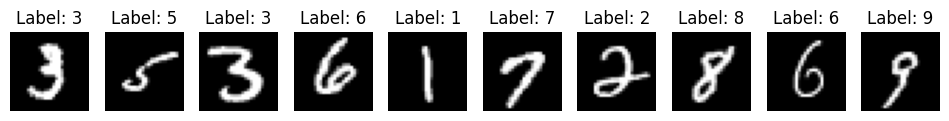

In [6]:
# Show some of the images
num_images_to_show = 10

plt.figure(figsize=(12, 6))
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i+1)
    plt.imshow(train_data[i+10], cmap='gray')
    plt.title(f"Label: {train_labels[i+10]}")
    plt.axis('off')

plt.show()

In [5]:
def select_samples_per_class(x_data, y_data, num_samples):
    selected_indices = []
    for class_label in np.unique(y_data):
        class_indices = np.where(y_data == class_label)[0]
        selected_indices.extend(np.random.choice(class_indices, num_samples, replace=False))
    x_data = np.array(x_data)
    return x_data[selected_indices], y_data[selected_indices]

# Choose 200 examples per class for the training set
num_train_samples_per_class = 500
x_train_selected, y_train_selected = select_samples_per_class(train_vectors, train_labels, num_train_samples_per_class)

# Choose 50 examples per class for the test subset
num_test_samples_per_class = 100
x_test_selected, y_test_selected = select_samples_per_class(test_vectors, test_labels, num_test_samples_per_class)
print(x_train_selected.shape)

(5000, 784)


In [6]:
# Shuffle the selected training data
shuffle_indices = np.random.permutation(len(x_train_selected))
x_train_subset = x_train_selected[shuffle_indices]
y_train_subset = y_train_selected[shuffle_indices]

# Split the test subset into features and labels
x_test_subset, y_test_subset = x_test_selected, y_test_selected


# # Normalize the pixel values to the range [0, 1]
x_train_subset = x_train_subset.astype('float32') / 255.0
x_test_subset = x_test_subset.astype('float32') / 255.0


In [7]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = x_train_subset, x_test_subset, y_train_subset , y_test_subset

In [8]:
# Split dataset into train and test sets
# X_train, X_test, y_train, y_test = train_vectors, test_vectors, train_labels , test_labels

In [9]:
print(X_train.shape,X_test.shape)

(5000, 784) (1000, 784)


In [10]:
# Perform PCA for dimensionality reduction

pca = PCA(n_components=40)
X_train_40 = pca.fit_transform(X_train)
X_test_40 = pca.transform(X_test)

pca = PCA(n_components=100)
X_train_100 = pca.fit_transform(X_train)
X_test_100 = pca.transform(X_test)

# Crammer Singer Machine

Just set hyperparameters and start running

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
class CrammerSingerSVM:
  def __init__(self,X_train,Y_train,X_test,Y_test,threshold,max_iter,beta=1.0,epsilon=0.001,epsilon_0=0.001,kernel_function='RBF',gamma='scale',degree=5):
    self.beta = beta
    self.epsilon = epsilon
    self.epsilon_0 = epsilon_0
    self.kernel_function = kernel_function
    self.gamma = gamma
    self.degree = degree
    self.X_train = X_train
    self.X_test = X_test
    self.Y_test = Y_test
    self.threshold = threshold
    self.max_iter = max_iter


    classes = np.unique(Y_train)
    self.num_classes = len(classes)
    self.num_examples = self.X_train.shape[0]
    self.num_features = self.X_train.shape[1]

    self.Tau = np.zeros((self.num_examples,self.num_classes)) # i*r

    Y_train = np.array(Y_train).reshape(-1, 1)
    delta_train = OneHotEncoder(sparse_output=False).fit_transform(Y_train)     #one_hot_labels
    self.Y_train = delta_train

    self.F = (-1*self.beta) * self.Y_train

    self.A = []
    for index, row in enumerate(self.X_train):
      K_i_i = self.kernel(self.kernel_function,row , row)
      self.A.append(K_i_i)
    self.A = np.array(self.A) # a vector


  def kernel(self,kernel_function,a,b):

    match kernel_function:
      case 'linear':
        return np.dot(a,b.T)

      case 'polynomial':
        return (np.dot(a, b.T) + 1) ** self.degree

      case 'RBF':
        if self.gamma == 'scale':
          self.gamma = 1 / (self.num_features * self.X_train.var())
          print("gamma=",self.gamma)
        return np.exp(-self.gamma*np.linalg.norm(np.array(a) - np.array(b)) ** 2 )

  def runSVM(self):
    self.Tau = self.train_machine() #multipliers(weights)
    self.norms = np.linalg.norm(self.Tau, ord=2, axis=1)
    # non_zero_indices = np.argwhere((norms >= self.threshold).any())
    non_zero_indices = []
    for i, norm in enumerate(self.norms):
      print("pattern" , i , "norm:" , norm)
      if norm > self.threshold:
        non_zero_indices.append(i)

    self.support_weights = np.squeeze(self.Tau[non_zero_indices])
    self.support_patterns = np.squeeze(self.X_train[non_zero_indices])
    self.support_labels = np.squeeze(self.Y_train[non_zero_indices])
    # self.visualizePatterns()

    print("I am in Predict phase.")
    print("Number of Support Patterns" , len(non_zero_indices))

    H_matrix_train = []
    for i,ex in enumerate(self.X_train):
      H_matrix_train.append(self.predict(ex))
    H_matrix_train = np.array(H_matrix_train)

    H_matrix_test = []
    for i,ex in enumerate(self.X_test):
      H_matrix_test.append(self.predict(ex))

    H_matrix_test = np.array(H_matrix_test)
    return H_matrix_train , H_matrix_test # containing class for each test data point
    # return H_matrix_test


  def predict(self,x):
    # calculating confidence score for each label for sample x #
    num_support_patterns = self.support_patterns.shape[0]
    output_x = np.zeros(self.num_classes)
    for r in range(self.num_classes):
      summation = 0
      for i in range(num_support_patterns):
        summation = summation + (self.support_weights[i][r] * self.kernel(self.kernel_function,x,self.support_patterns[i]))
      output_x[r] = summation


    predicted_label = np.argmax(output_x)
    return predicted_label


  def train_machine(self):
    optimized = False
    index_holder = [] # a list
    iter = 0
    while not optimized:
      print("Round:" , iter)
      example_idx , psi = self.example_selection(self.X_train,self.Y_train,self.F,self.Tau)
      index_holder.append(example_idx)
      A_ex = self.A[example_idx] # a scalar
      label_ex = self.Y_train[example_idx]
      B_ex = self.calculate_B(example_idx,self.beta,self.X_train,label_ex,self.kernel_function,self.Tau)
      sum_D_r = 0
      D_ex = np.zeros(self.num_classes)
      for r in range(self.num_classes):
        D_r = np.array((self.F[example_idx][r] / A_ex) - self.Tau[example_idx][r] + label_ex[r])
        D_ex[r] = D_r

      sum_D_r = sum(D_ex)

      theta = ((1/self.num_classes) * sum_D_r) - (1/self.num_classes)
      Tau_ex_optimum = self.FixedPointAlgorithm(D_ex,theta,self.epsilon/2,A_ex,B_ex)
      difference_tau = Tau_ex_optimum - self.Tau[example_idx] # for example p
      self.F = self.update_F(self.F,difference_tau,self.kernel_function,example_idx,self.X_train)
      self.Tau[example_idx] = Tau_ex_optimum

      if psi[example_idx] < self.epsilon * self.beta or iter == self.max_iter:
      # or index_holder.count(example_idx) >= 3:
        optimized = True
      iter += 1

    return self.Tau #matrix containing weights of samples(support vectors)


  def example_selection(self,data,data_labels,F,Tau):

    psi_matrix = np.zeros(self.num_examples)
    for i , ex in enumerate(data):
      F_i = F[i] # a vector
      F_i_max = np.max(F_i) # maximum confidence score assigning to label r
      smaller_idx = []
      for r in range(self.num_classes):
        if Tau[i][r] < data_labels[i][r]:
          smaller_idx.append(r)
      F_i_min = np.min(F_i[smaller_idx]) # there must be at least one label r that satisfies this condition
      psi = F_i_max - F_i_min
      psi_matrix[i] = psi

    p_idx = np.argmax(psi_matrix)

    return p_idx , psi_matrix

  def FixedPointAlgorithm(self,D,theta,epsilon,A,B):
    l = 0
    theta_l = theta
    while True:
      l += 1
      max_array = np.zeros(self.num_classes)
      for r in range(self.num_classes):
        max_array[r] = max(theta_l,D[r])
      theta_l_prim = (1/self.num_classes * sum(max_array)) - 1 / self.num_classes
      if abs((theta_l - theta_l_prim) / theta_l) <= epsilon:
        break
      else:
        theta_l = theta_l_prim

    V = np.zeros(self.num_classes)
    for r in range(self.num_classes):
      b = min(theta_l_prim,D[r])
      V[r] = b

    Tau_star = V - (B / A)
    return Tau_star

  def calculate_B(self,p,beta,data,label_p,kernel_function,Tau):
    summation = np.zeros(self.num_classes)
    for i , x in enumerate(data):
      if i != p:
        holder = self.kernel(kernel_function,data[p],data[i])
        summation = summation + (holder * Tau[i]) # a row

    Bp = (-1 * beta * label_p) + summation  # a vector
    return Bp

  def update_F(self,F,difference_tau,kernel_function,p,data):
    for m in range(self.num_examples):
      kernel_result = self.kernel(kernel_function,data[p],data[m])

      for r in range(self.num_classes):
        F[m][r] = F[m][r] + (difference_tau[r] * kernel_result)

    return F

                                        ### Visualization ####
  def visualizePatterns(self):
    # min_max_scaler = preprocessing.MinMaxScaler()
    # X_normal = min_max_scaler.fit_transform(X)
    for x in self.X_train:
      if x not in self.support_patterns:
        plt.scatter(x[0], x[1] , c='blue',edgecolors='k',marker='o',)
      else:
        plt.scatter(x[0], x[1] , c = 'green',marker='x')
    plt.title("Multi Class SVM blob data with Support Patterns")
    return True

Build your instance

#1. origin data , linear , beta = 0.01


In [19]:
crammerSinger_instance = CrammerSingerSVM(X_train,y_train,X_test,y_test,threshold=0.0,max_iter = 2000,beta = 0.01,epsilon =0.01,kernel_function='linear')

In [20]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0001264569087299441
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.0
pattern 69 norm: 0.0
pattern 70 norm: 0.0
pattern 71 norm: 0.0
pattern 72 norm: 0.0
pattern 73 norm: 0.0
pattern

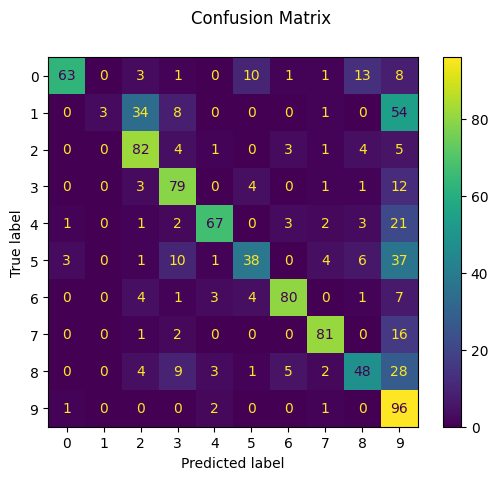

Train Accuracy: 0.67
Accuracy: 0.64
precision : 0.637
recall :  0.637
f1_score:  0.637


In [21]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

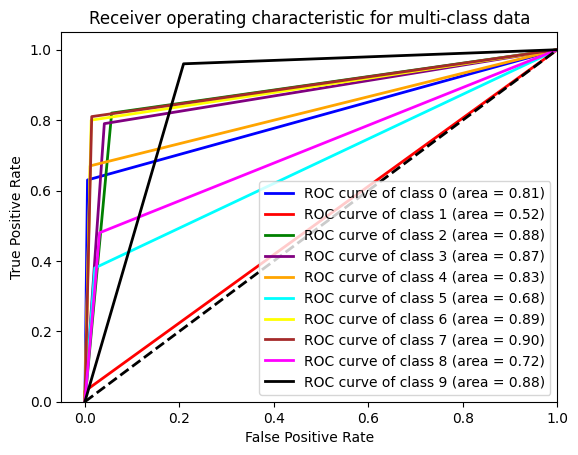

AUC: 0.7983333333333332


In [22]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#2. origin data , linear , beta = 1

In [25]:
crammerSinger_instance = CrammerSingerSVM(X_train,y_train,X_test,y_test,threshold=0.0,max_iter = 2000,beta = 1,epsilon =0.01,kernel_function='linear')

In [26]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.019395910277837335
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.0
pattern 69 norm: 0.0
pattern 70 norm: 0.0
pattern 71 norm: 0.0
pattern 72 norm: 0.018200578306480055
pattern 73 n

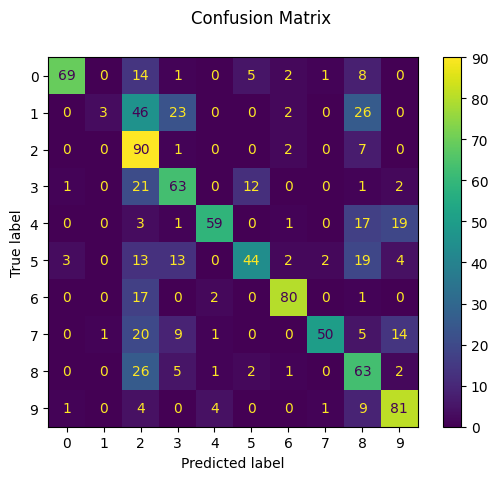

Train Accuracy: 0.62
Accuracy: 0.60
precision : 0.602
recall :  0.602
f1_score:  0.602


In [27]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

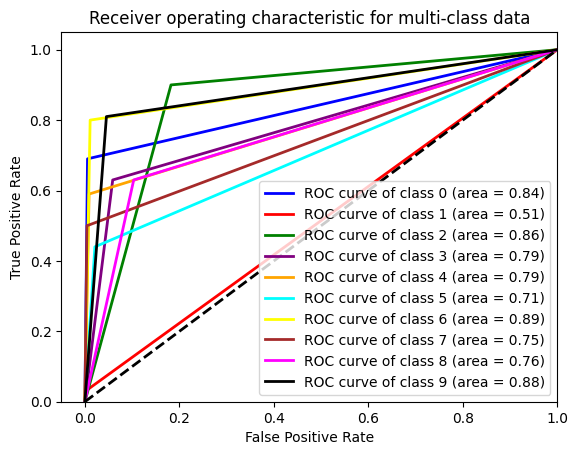

AUC: 0.7788888888888889


In [28]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#3. origin data , linear , beta = 100

In [29]:
crammerSinger_instance = CrammerSingerSVM(X_train,y_train,X_test,y_test,threshold=0.0,max_iter = 2000,beta = 100,epsilon =0.01,kernel_function='linear')

In [30]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
# print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 2 norm: 0.0
pattern 3 norm: 0.0
pattern 4 norm: 0.0
pattern 5 norm: 0.0
pattern 6 norm: 0.0
pattern 7 norm: 0.0
pattern 8 norm: 0.0
pattern 9 norm: 0.0
pattern 10 norm: 0.0
pattern 11 norm: 1.1783906915639326
pattern 12 norm: 0.0
pattern 13 norm: 0.0
pattern 14 norm: 0.0
pattern 15 norm: 0.0
pattern 16 norm: 0.9011330927850444
pattern 17 norm: 0.0
pattern 18 norm: 0.0
pattern 19 norm: 1.1903399248372926
pattern 20 norm: 0.0
pattern 21 norm: 0.0
pattern 22 norm: 0.0
pattern 23 norm: 0.0
pattern 24 norm: 0.0
pattern 25 norm: 1.1949099185221839
pattern 26 norm: 0.0
pattern 27 norm: 0.0
pattern 28 norm: 0.0
pattern 29 norm: 0.0
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm

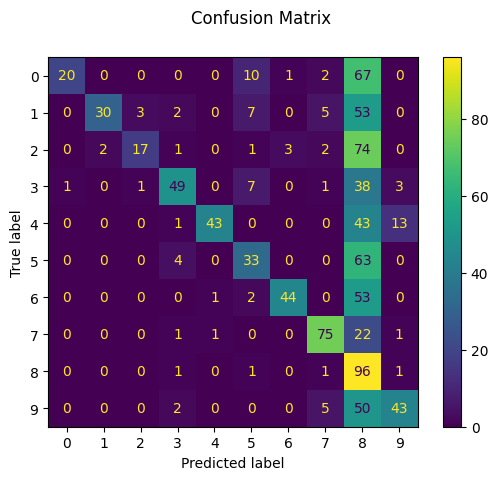

Train Accuracy: 0.47
Accuracy: 0.45
precision : 0.45
recall :  0.45
f1_score:  0.45


In [31]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

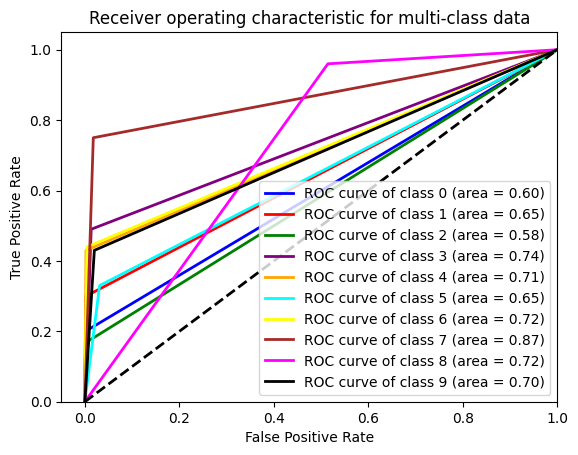

AUC: 0.6944444444444444


In [32]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#4. pca100 , linear , beta = 1e-5

In [13]:
crammerSinger_instance = CrammerSingerSVM(X_train_100,y_train,X_test_100,y_test,threshold=0.0,max_iter = 2000,beta = 1e-5,epsilon =0.01,kernel_function='linear')

In [14]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
# print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 2 norm: 0.0
pattern 3 norm: 0.0
pattern 4 norm: 0.0
pattern 5 norm: 0.0
pattern 6 norm: 0.0
pattern 7 norm: 1.9803089403942694e-07
pattern 8 norm: 0.0
pattern 9 norm: 0.0
pattern 10 norm: 0.0
pattern 11 norm: 0.0
pattern 12 norm: 4.809652910834591e-07
pattern 13 norm: 0.0
pattern 14 norm: 0.0
pattern 15 norm: 0.0
pattern 16 norm: 0.0
pattern 17 norm: 0.0
pattern 18 norm: 0.0
pattern 19 norm: 0.0
pattern 20 norm: 0.0
pattern 21 norm: 0.0
pattern 22 norm: 0.0
pattern 23 norm: 0.0
pattern 24 norm: 0.0
pattern 25 norm: 0.0
pattern 26 norm: 0.0
pattern 27 norm: 0.0
pattern 28 norm: 0.0
pattern 29 norm: 0.0
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 

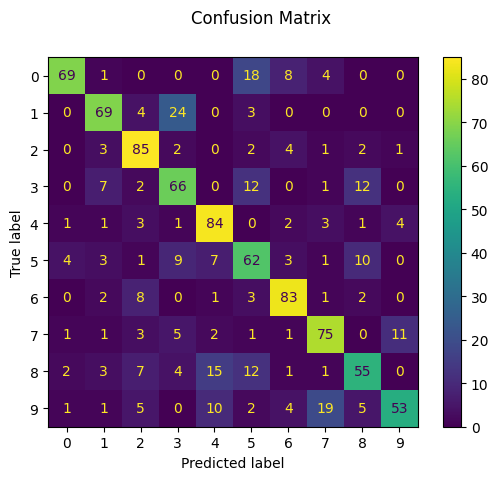

Train Accuracy: 0.70
Accuracy: 0.70
precision : 0.701
recall :  0.701
f1_score:  0.701


In [15]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

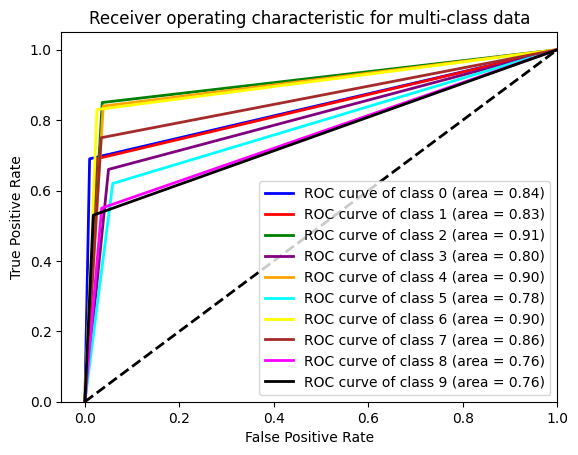

AUC: 0.8338888888888889


In [16]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#5. pca100 , linear , beta = 1e-3

In [17]:
crammerSinger_instance = CrammerSingerSVM(X_train_100,y_train,X_test_100,y_test,threshold=0.0,max_iter = 2000,beta = 1e-3,epsilon =0.01,kernel_function='linear')

In [18]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
# print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 2 norm: 0.0
pattern 3 norm: 0.0
pattern 4 norm: 0.0
pattern 5 norm: 0.0
pattern 6 norm: 0.0
pattern 7 norm: 1.9803089404444134e-05
pattern 8 norm: 0.0
pattern 9 norm: 0.0
pattern 10 norm: 0.0
pattern 11 norm: 0.0
pattern 12 norm: 1.7064452729177025e-05
pattern 13 norm: 0.0
pattern 14 norm: 0.0
pattern 15 norm: 0.0
pattern 16 norm: 0.0
pattern 17 norm: 0.0
pattern 18 norm: 0.0
pattern 19 norm: 0.0
pattern 20 norm: 0.0
pattern 21 norm: 0.0
pattern 22 norm: 0.0
pattern 23 norm: 0.0
pattern 24 norm: 0.0
pattern 25 norm: 0.0
pattern 26 norm: 0.0
pattern 27 norm: 0.0
pattern 28 norm: 0.0
pattern 29 norm: 0.0
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm:

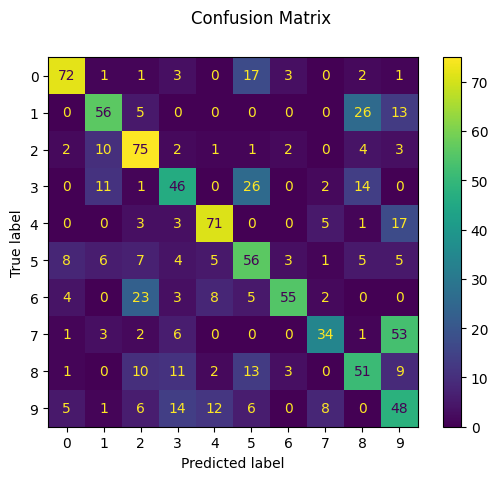

Train Accuracy: 0.56
Accuracy: 0.56
precision : 0.564
recall :  0.564
f1_score:  0.564


In [19]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

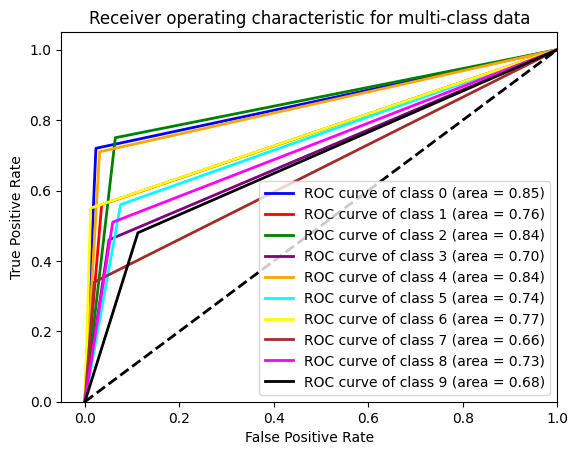

AUC: 0.7577777777777778


In [20]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#6. pca100 , linear , beta = 1

In [37]:
crammerSinger_instance = CrammerSingerSVM(X_train_100,y_train,X_test_100,y_test,threshold=0.0,max_iter = 2000,beta = 1,epsilon =0.01,kernel_function='linear')

In [38]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
# print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 2 norm: 0.0
pattern 3 norm: 0.0
pattern 4 norm: 0.0
pattern 5 norm: 0.0365996770165315
pattern 6 norm: 0.0
pattern 7 norm: 0.0
pattern 8 norm: 0.0
pattern 9 norm: 0.0
pattern 10 norm: 0.0
pattern 11 norm: 0.15703924733477664
pattern 12 norm: 0.0
pattern 13 norm: 0.0
pattern 14 norm: 0.0
pattern 15 norm: 0.0
pattern 16 norm: 0.021315487884960904
pattern 17 norm: 0.0
pattern 18 norm: 0.0
pattern 19 norm: 0.049411099256492466
pattern 20 norm: 0.024329881528359517
pattern 21 norm: 0.0
pattern 22 norm: 0.0
pattern 23 norm: 0.0
pattern 24 norm: 0.0
pattern 25 norm: 0.0
pattern 26 norm: 0.0
pattern 27 norm: 0.0
pattern 28 norm: 0.04085426145202461
pattern 29 norm: 0.0
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.

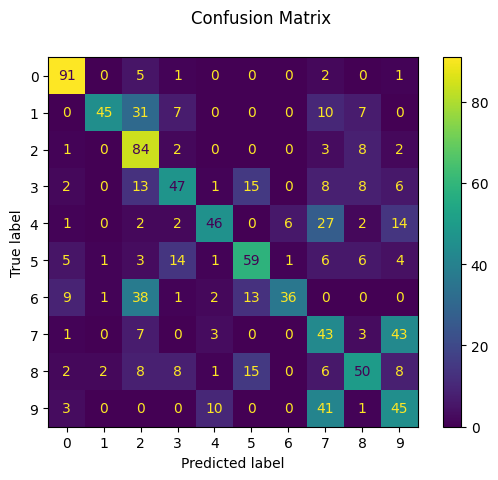

Train Accuracy: 0.57
Accuracy: 0.55
precision : 0.546
recall :  0.546
f1_score:  0.546


In [39]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

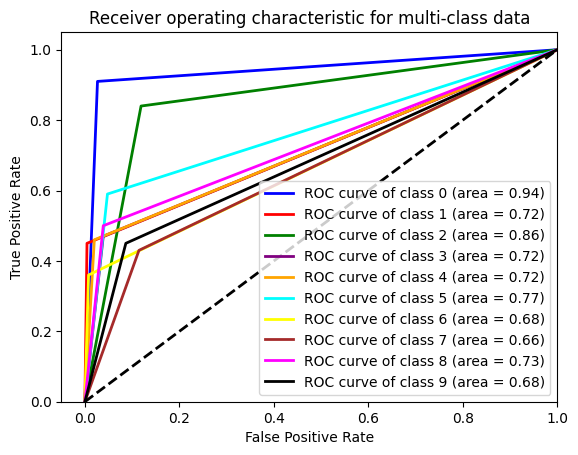

AUC: 0.7477777777777777


In [40]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#7. pca40 , linear , beta = 1e-5


In [21]:
crammerSinger_instance = CrammerSingerSVM(X_train_40,y_train,X_test_40,y_test,threshold=0.0,max_iter = 2000,beta = 1e-5,epsilon =0.01,kernel_function='linear')

In [22]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 2.551331206517799e-07
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 9.986118766119427e-07
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 9.863416437941346e-07
pattern 58 norm: 4.0566370192678345e-07
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 3.8906644342167554e-07
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.0
pattern 69 norm: 0.0
pattern 70 norm: 

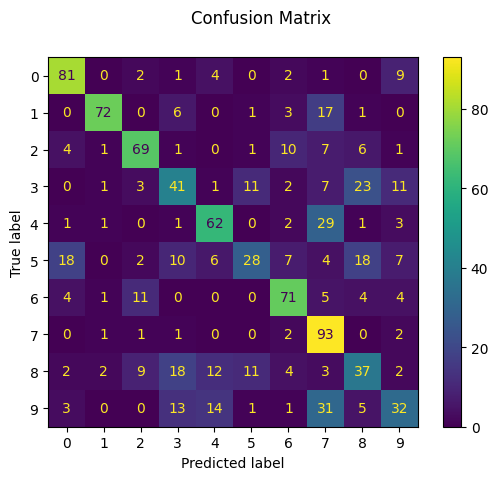

Train Accuracy: 0.57
Accuracy: 0.59
precision : 0.586
recall :  0.586
f1_score:  0.586


In [23]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

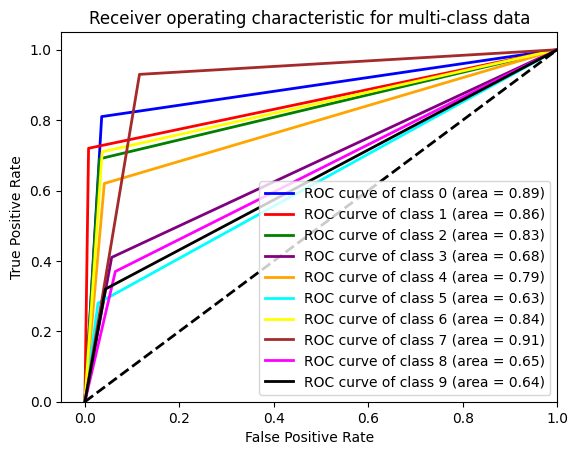

AUC: 0.77


In [24]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#8. pca40 , linear , beta = 1e-3

In [25]:
crammerSinger_instance = CrammerSingerSVM(X_train_40,y_train,X_test_40,y_test,threshold=0.0,max_iter = 2000,beta = 1e-3,epsilon =0.01,kernel_function='linear')

In [26]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 2.5513312065433666e-05
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 2.5497401111272445e-05
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.0
pattern 69 norm: 0.0
pattern 70 norm: 0.0
pattern 71 norm: 0.0
pattern 72 norm: 0.0
pattern 

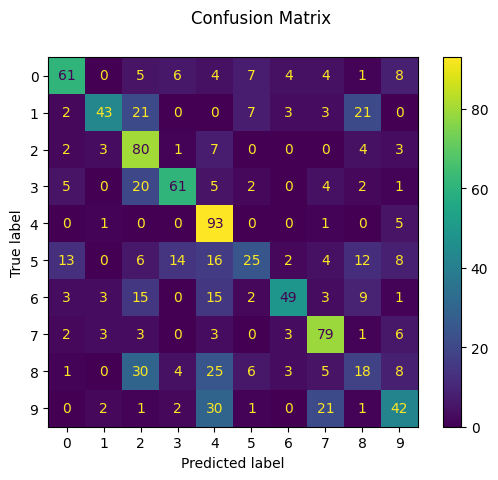

Train Accuracy: 0.54
Accuracy: 0.55
precision : 0.551
recall :  0.551
f1_score:  0.551


In [27]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

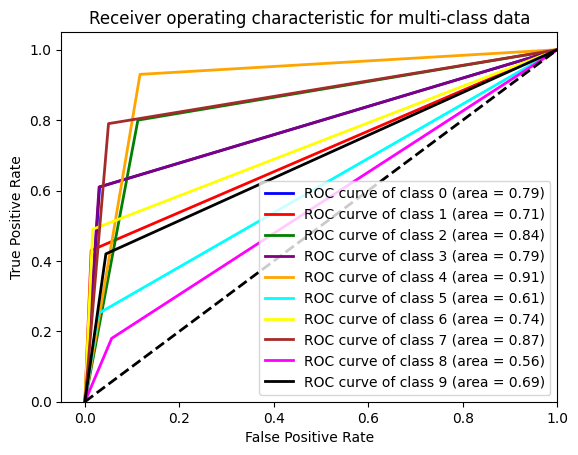

AUC: 0.7505555555555555


In [28]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#9. pca40 , linear , beta = 1

In [98]:
crammerSinger_instance = CrammerSingerSVM(X_train_40,y_train,X_test_40,y_test,threshold=0.0,max_iter = 2000,beta = 1,epsilon =0.01,kernel_function='linear')

In [99]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.05015831041643442
pattern 67 norm: 0.0
pattern 68 norm: 0.0
pattern 69 norm: 0.0
pattern 70 norm: 0.02717934232908339
pattern 71 norm: 0.0
pattern 72 norm: 0.0
pattern 73 nor

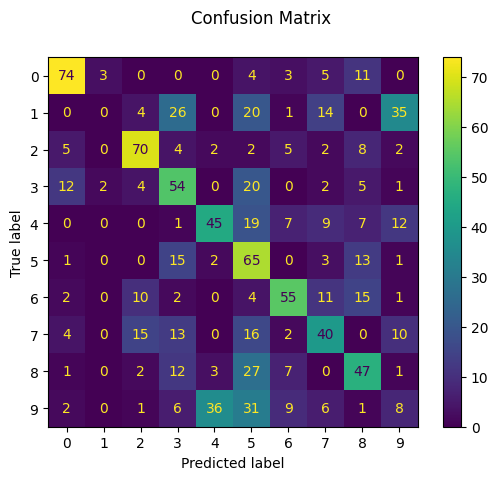

Train Accuracy: 0.46
Accuracy: 0.46
precision : 0.458
recall :  0.458
f1_score:  0.458


In [100]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

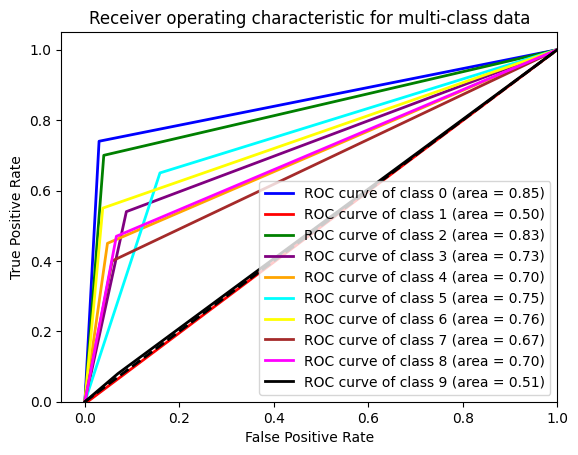

AUC: 0.6988888888888888


In [101]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#1. origin data , RBF , beta = 0.1 , gamma = 1e-2


In [29]:
crammerSinger_instance = CrammerSingerSVM(X_train,y_train,X_test,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1e-2)

In [30]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.11684639986879308
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.10946424418931189
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0974824288759226
pattern 64 norm: 0.13848422558148094
pattern 65 norm: 0.0
pattern 66 norm: 0.09869615763798996
pattern 67 norm: 0.12870355047863818
pattern 68 norm: 0.0
pattern 69 norm: 0.1144764296577938

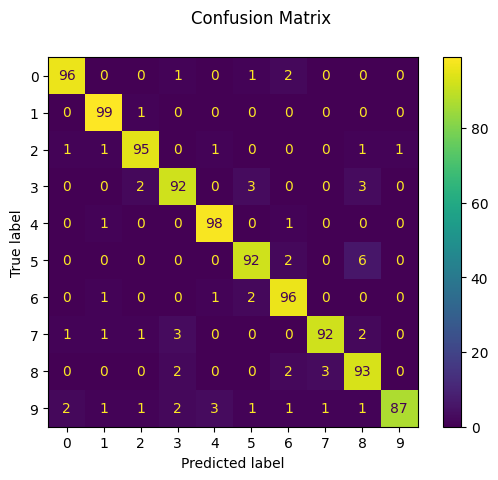

Train Accuracy: 1.00
Accuracy: 0.94
precision : 0.94
recall :  0.94
f1_score:  0.94


In [31]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

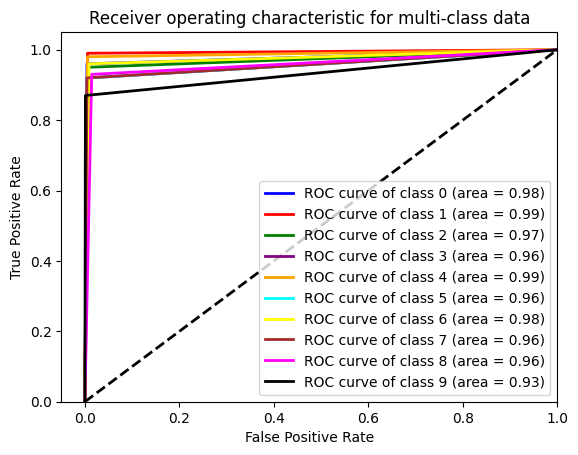

AUC: 0.9666666666666668


In [32]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#2. origin data , RBF , beta = 0.1 , gamma = 1e-1

In [33]:
crammerSinger_instance = CrammerSingerSVM(X_train,y_train,X_test,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1e-1)

In [34]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.0936884374139911
pattern 33 norm: 0.08814022226729155
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.08662076265066539
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.09289000526504217
pattern 42 norm: 0.08855107855270648
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.09485102291317288
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.09409395701003292
pattern 51 norm: 0.0
pattern 52 norm: 0.0938663888306039
pattern 53 norm: 0.0891334191524013
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0901508856774954
pattern 58 norm: 0.0944528002115047
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0
pattern 64 norm: 0.09404790811316018
pattern 65 norm: 0.09438679

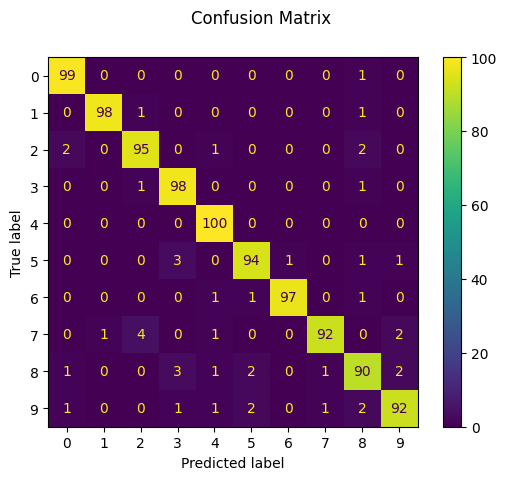

Train Accuracy: 1.00
Accuracy: 0.95
precision : 0.955
recall :  0.955
f1_score:  0.955


In [35]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

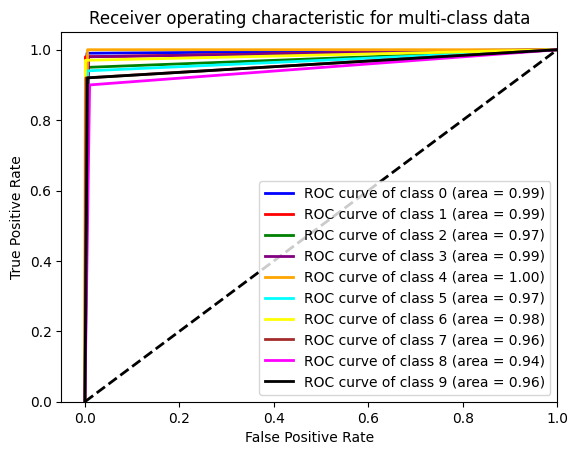

AUC: 0.975


In [36]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#3. origin data , RBF , beta = 0.1 , gamma = 1

In [37]:
crammerSinger_instance = CrammerSingerSVM(X_train,y_train,X_test,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1)

In [38]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.0
pattern 32 norm: 0.09486832980505137
pattern 33 norm: 0.09486832980505137
pattern 34 norm: 0.09486832980505137
pattern 35 norm: 0.09486832980505137
pattern 36 norm: 0.09486832980505137
pattern 37 norm: 0.09486832980505137
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.09486832980505137
pattern 41 norm: 0.09486832980505137
pattern 42 norm: 0.09486832980505137
pattern 43 norm: 0.0
pattern 44 norm: 0.09486832980505139
pattern 45 norm: 0.09486832980505137
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.09486832980505137
pattern 49 norm: 0.09486832980505137
pattern 50 norm: 0.09486832980505137
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.09486832980505137
pattern 54 norm: 0.09486832980505137
pattern 55 norm: 0.0
pattern 56 norm: 0.09486832980505137
pattern 57 norm: 0.09486832980505137
pattern 58 norm: 0.09486832980505137
pattern 59 norm: 0.0
pattern 60 norm

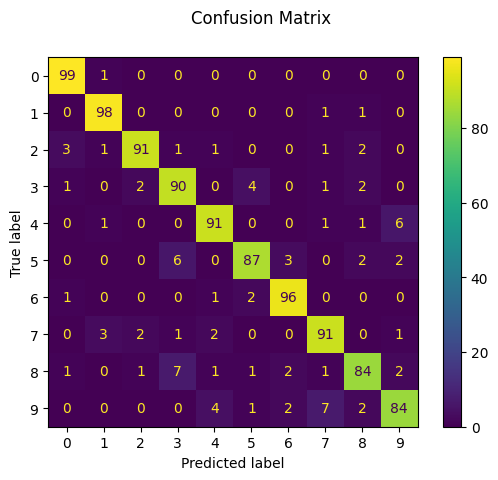

Train Accuracy: 1.00
Accuracy: 0.91
precision : 0.911
recall :  0.911
f1_score:  0.911


In [39]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

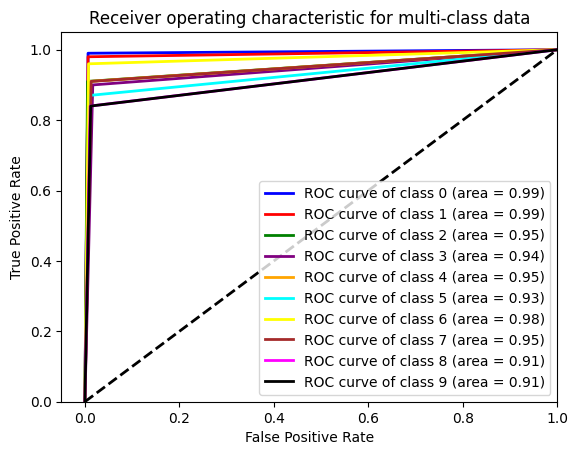

AUC: 0.9505555555555556


In [40]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#4. pca100 , RBF , beta = 0.1 , gamma = 1e-9

In [69]:
crammerSinger_instance = CrammerSingerSVM(X_train_100,y_train,X_test_100,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1e-9)

In [70]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.4690415880190223
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.14142135800384356
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.14142136220692986
pattern 55 norm: 0.1414213611446385
pattern 56 norm: 0.0
pattern 57 norm: 0.14142135925683108
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.14142136040496062
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.14142135749394813
pattern 69 norm: 0.0

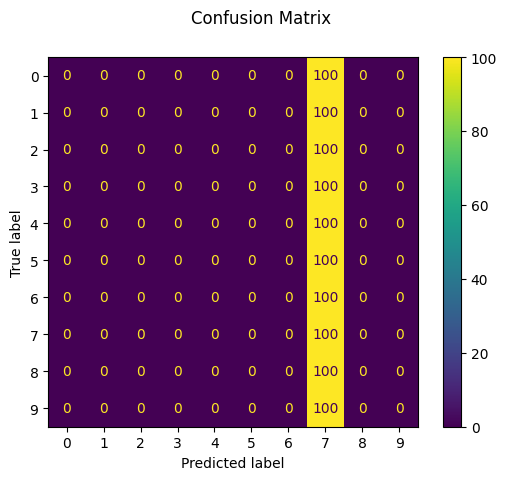

Train Accuracy: 0.10
Accuracy: 0.10
precision : 0.1
recall :  0.1
f1_score:  0.10000000000000002


In [71]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

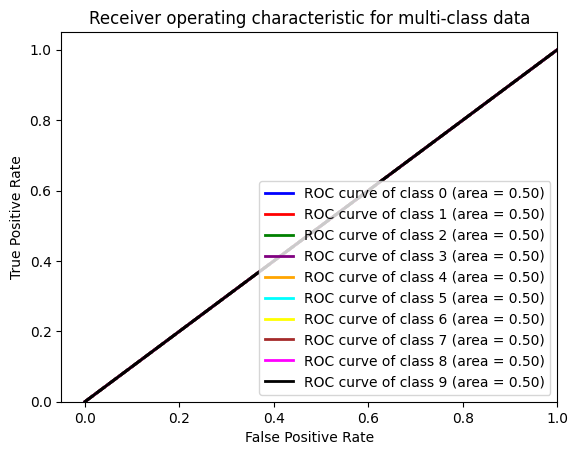

AUC: 0.5


In [72]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#5. pca100 , RBF , beta = 0.1 , gamma = 1e-6

In [73]:
crammerSinger_instance = CrammerSingerSVM(X_train_100,y_train,X_test_100,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1e-6)

In [74]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.469053601176132
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.141423117377103
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.14142027610437588
pattern 51 norm: 0.0
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.0
pattern 55 norm: 0.14142626323228275
pattern 56 norm: 0.0
pattern 57 norm: 0.14142436957686608
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.1414255215735788
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.14142260863443842
pattern 69 norm: 0.0
pa

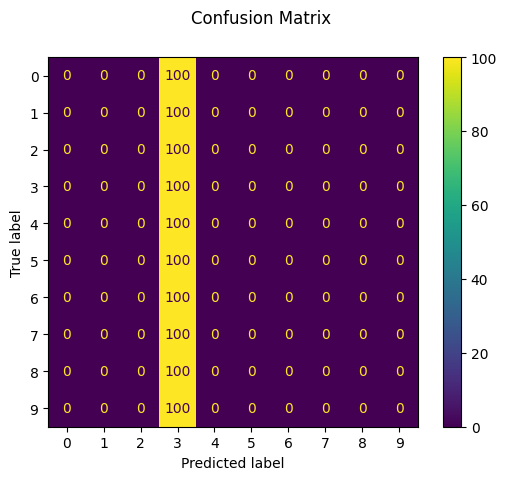

Train Accuracy: 0.10
Accuracy: 0.10
precision : 0.1
recall :  0.1
f1_score:  0.10000000000000002


In [75]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

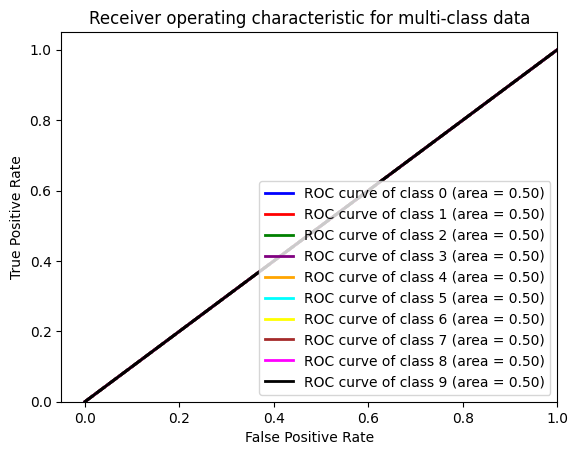

AUC: 0.5


In [76]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#6. pca100 , RBF , beta = 0.1 , gamma = 1

In [77]:
crammerSinger_instance = CrammerSingerSVM(X_train_100,y_train,X_test_100,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1)

In [78]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.09486832980505137
pattern 32 norm: 0.09486832980504997
pattern 33 norm: 0.0
pattern 34 norm: 0.09486832980505137
pattern 35 norm: 0.0
pattern 36 norm: 0.09486832980505137
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.09486832980505137
pattern 40 norm: 0.0
pattern 41 norm: 0.0948683298050441
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.09486832980505137
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.09486832980505092
pattern 50 norm: 0.09486832980505137
pattern 51 norm: 0.09486832980505137
pattern 52 norm: 0.0
pattern 53 norm: 0.09486832981330333
pattern 54 norm: 0.09486832980505137
pattern 55 norm: 0.09486832980505137
pattern 56 norm: 0.09486832980505137
pattern 57 norm: 0.09486832980518094
pattern 58 norm: 0.09486832981816472
pattern 59 norm: 0.09486832980505137
pattern 60 norm: 0.09486832980505135
pattern 61 

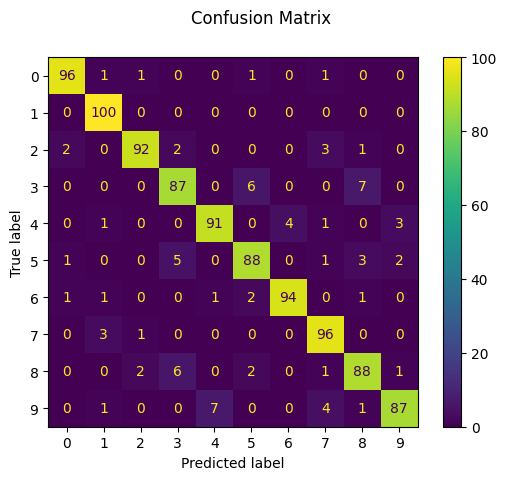

Train Accuracy: 1.00
Accuracy: 0.92
precision : 0.919
recall :  0.919
f1_score:  0.919


In [79]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

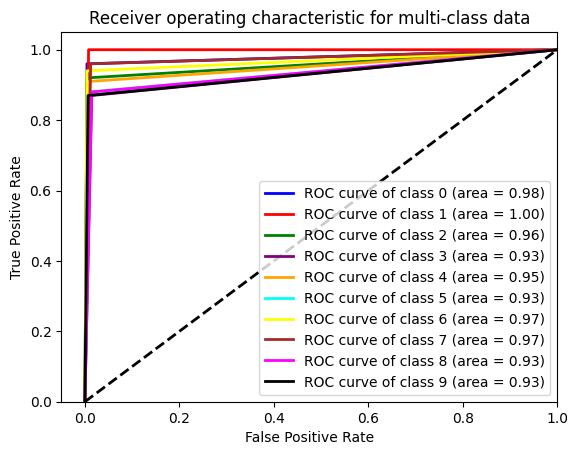

AUC: 0.9550000000000001


In [80]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#7. pca40 , RBF , beta = 0.1 , gamma = 1e-9


In [81]:
crammerSinger_instance = CrammerSingerSVM(X_train_40,y_train,X_test_40,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1e-9)

In [82]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.3464101706264106
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.0
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.141421359619134
pattern 52 norm: 0.0
pattern 53 norm: 0.14142135763319108
pattern 54 norm: 0.0
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.0
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.14142135903351155
pattern 69 norm: 0.0
pattern 70 norm: 0.0
pattern 71 norm: 0.0
patter

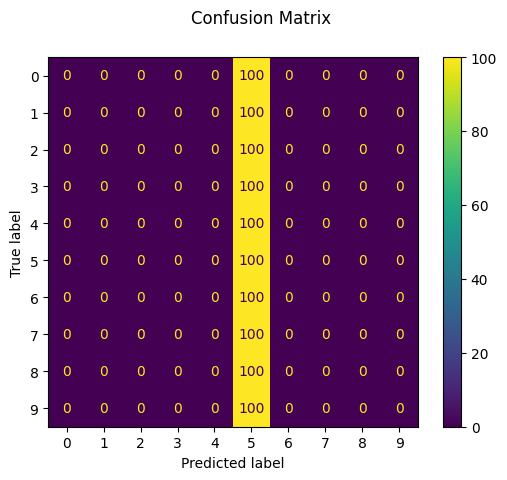

Train Accuracy: 0.10
Accuracy: 0.10
precision : 0.1
recall :  0.1
f1_score:  0.10000000000000002


In [83]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

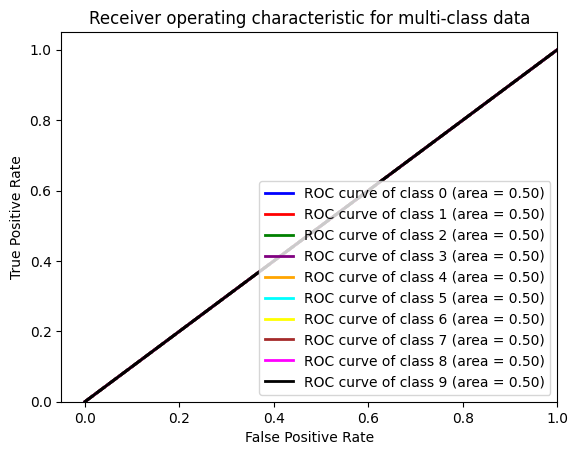

AUC: 0.5


In [84]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#8. pca40 , RBF , beta = 0.1 , gamma = 1e-6

In [85]:
crammerSinger_instance = CrammerSingerSVM(X_train_40,y_train,X_test_40,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1e-6)

In [86]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.8944573606771943
pattern 32 norm: 0.0
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.1414253677421698
pattern 36 norm: 0.14142286767323878
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.14142006444849295
pattern 40 norm: 0.0
pattern 41 norm: 0.0
pattern 42 norm: 0.0
pattern 43 norm: 0.0
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.14142543153486195
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.0
pattern 51 norm: 0.24495520553787592
pattern 52 norm: 0.0
pattern 53 norm: 0.0
pattern 54 norm: 0.2449577225866172
pattern 55 norm: 0.0
pattern 56 norm: 0.0
pattern 57 norm: 0.0
pattern 58 norm: 0.14142261610088117
pattern 59 norm: 0.0
pattern 60 norm: 0.0
pattern 61 norm: 0.0
pattern 62 norm: 0.0
pattern 63 norm: 0.0
pattern 64 norm: 0.0
pattern 65 norm: 0.0
pattern 66 norm: 0.0
pattern 67 norm: 0.0
pattern 68 norm: 0.0
patte

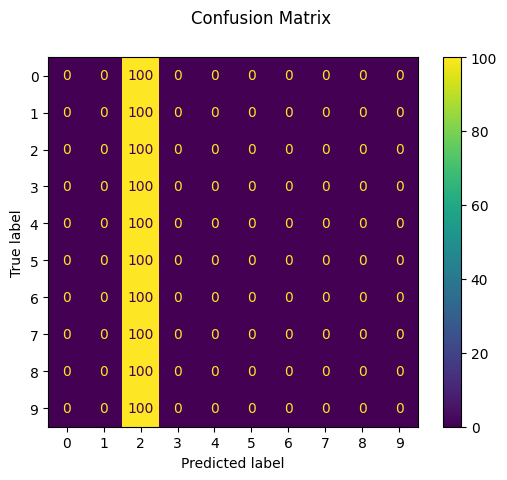

Train Accuracy: 0.10
Accuracy: 0.10
precision : 0.1
recall :  0.1
f1_score:  0.10000000000000002


In [87]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

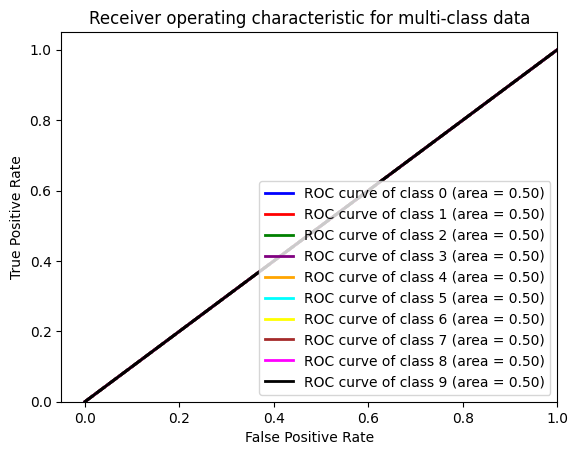

AUC: 0.5


In [88]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

#9. pca40 , RBF , beta = 0.1 , gamma = 1

In [89]:
crammerSinger_instance = CrammerSingerSVM(X_train_40,y_train,X_test_40,y_test,threshold=0.0,max_iter = 2000,beta = 0.1,epsilon =0.01,kernel_function='RBF',gamma = 1)

In [90]:
y_pred_train , y_pred = crammerSinger_instance.runSVM()
# y_pred = crammerSinger_instance.runSVM()
print(y_pred)

Streaming output truncated to the last 5000 lines.
pattern 30 norm: 0.0
pattern 31 norm: 0.09486833017382297
pattern 32 norm: 0.09486832964724355
pattern 33 norm: 0.0
pattern 34 norm: 0.0
pattern 35 norm: 0.0
pattern 36 norm: 0.09486832968871485
pattern 37 norm: 0.0
pattern 38 norm: 0.0
pattern 39 norm: 0.0
pattern 40 norm: 0.0
pattern 41 norm: 0.09486832356722956
pattern 42 norm: 0.0
pattern 43 norm: 0.09486832853647245
pattern 44 norm: 0.0
pattern 45 norm: 0.0
pattern 46 norm: 0.0
pattern 47 norm: 0.0
pattern 48 norm: 0.0
pattern 49 norm: 0.0
pattern 50 norm: 0.09486833302790518
pattern 51 norm: 0.0948683298013667
pattern 52 norm: 0.0
pattern 53 norm: 0.09486842182256154
pattern 54 norm: 0.09486832980506611
pattern 55 norm: 0.0
pattern 56 norm: 0.09486832917008271
pattern 57 norm: 0.0948684241209222
pattern 58 norm: 0.09488399252792092
pattern 59 norm: 0.09486832980504058
pattern 60 norm: 0.09486832964155023
pattern 61 norm: 0.09486832980505158
pattern 62 norm: 0.09486832976341988
pa

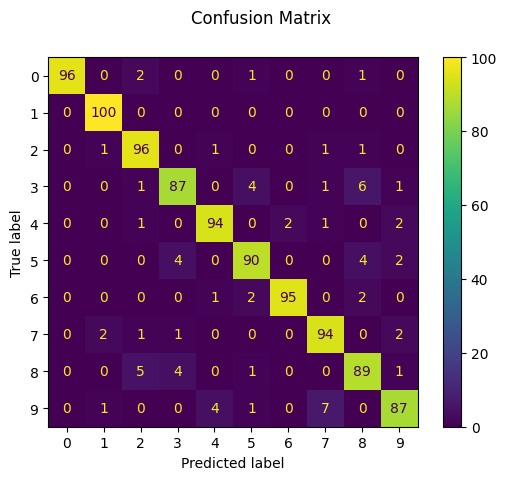

Train Accuracy: 1.00
Accuracy: 0.93
precision : 0.928
recall :  0.928
f1_score:  0.928


In [91]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Train Accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Train Accuracy: {train_accuracy:.2f}")
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

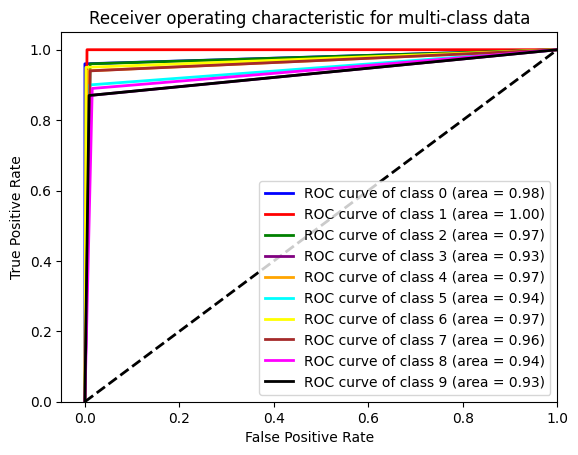

AUC: 0.9600000000000002


In [92]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)

# OVR single model

In [43]:
# Train a Logistic Regression classifier
clf = SVC(C=0.1,kernel='rbf',decision_function_shape='ovr')
clf.fit(X_train_40, y_train)

# Predict on test data
y_pred = clf.predict(X_test_40)

In [44]:
y_pred_train = clf.predict(X_train_40)

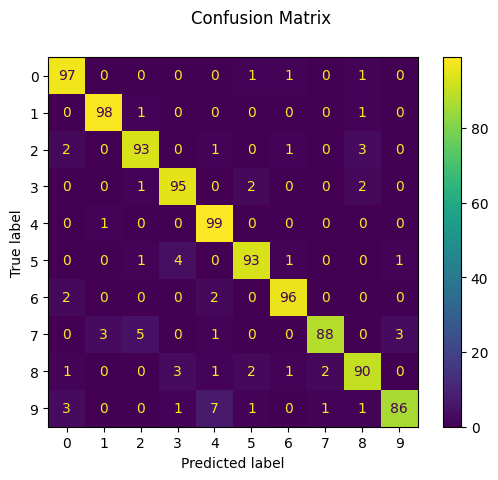

Accuracy: 0.93
Accuracy: 0.94
precision : 0.935
recall :  0.935
f1_score:  0.935


In [45]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

# Accuracy
Acc_train = accuracy_score(y_train, y_pred_train)
print(f"Accuracy: {Acc_train:.2f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# precision
precision = precision_score(y_test , y_pred , average = 'micro')
print("precision :" , precision)
# recall
recall = recall_score(y_test, y_pred , average='micro')
print("recall : " , recall)
# F1 score
print("f1_score: " , f1_score(y_test, y_pred , average='micro'))

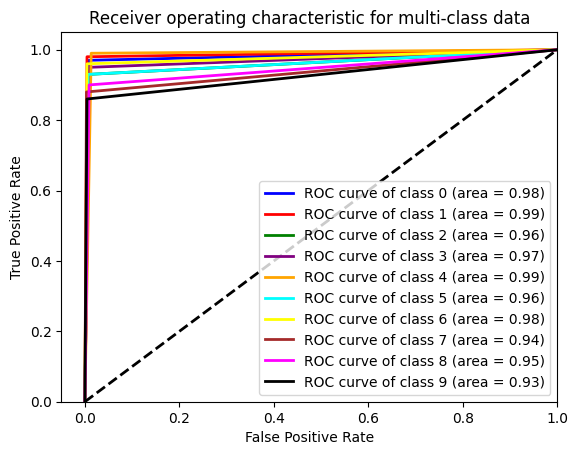

AUC: 0.9638888888888889


In [46]:
# binarize the output
# remove this and at last calculate to not come binarize values before this part

binarize_prediction_values = label_binarize(y_pred, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
binarizes_test_labels = label_binarize(y_test, classes=[0, 1, 2 , 3 , 4 , 5 , 6 , 7 ,8 , 9])
n_classes = 10

fpr = dict()
tpr = dict()
roc_auc = dict()
lw=2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarizes_test_labels[:, i], binarize_prediction_values[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','purple', 'orange', 'cyan','yellow', 'brown', 'magenta','black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# AUC
AUC= roc_auc_score(binarizes_test_labels, binarize_prediction_values , multi_class="ovr", average="macro")
print("AUC:" , AUC)